In [1]:
# mount google drive into colab
# THIS PROJECT COULD NOT HAVE BEEN DONE WITHOUT THE HELP FROM https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/ AND https://www.kaggle.com/datasnaek/chess
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import kaggle and download the datasets
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Chess EDA and Winner Regression Ensemble"

In [3]:
%cd /content/drive/MyDrive/Chess EDA and Winner Regression Ensemble

/content/drive/MyDrive/Chess EDA and Winner Regression Ensemble


Download the Dataset using Kaggle API


In [5]:
!kaggle datasets download -d datasnaek/chess

  0% 0.00/2.77M [00:00<?, ?B/s]
100% 2.77M/2.77M [00:00<00:00, 45.4MB/s]


In [4]:
!ls

chess_winner_prediction.sav  games.csv	kaggle.json


In [7]:
!unzip \*.zip  && rm *.zip

Archive:  chess.zip
replace games.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: games.csv               


Import Neccesary Packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read the CSV

In [6]:
df = pd.read_csv("games.csv")

In [7]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Define Some Values

In [8]:
rows, cols = df.shape[0], df.shape[1]
print(rows)

20058


Check for any Null Vales


In [9]:
df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [10]:
df.dtypes

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object

Looking at the Rating statistics

In [86]:
df['white_rating'].describe()

count    20058.000000
mean      1596.631868
std        291.253376
min        784.000000
25%       1398.000000
50%       1567.000000
75%       1793.000000
max       2700.000000
Name: white_rating, dtype: float64

In [87]:
df['black_rating'].describe()

count    20058.000000
mean      1588.831987
std        291.036126
min        789.000000
25%       1391.000000
50%       1562.000000
75%       1784.000000
max       2723.000000
Name: black_rating, dtype: float64

Key Takeaways (For Both Rating Categories)
* What we get from this description is we can see that the average rating is around 1600 which is most likely true to the rest of the world as well.

* We also see that the minimum of this data is 789 and although thats not too nice, we can reccomend our model to anybody who fills between that 700 - 2800 gap and nobody below.

# Rated or Unrated Games


In [11]:
df["rated"].value_counts(normalize=True) * 100

True     80.54143
False    19.45857
Name: rated, dtype: float64

([<matplotlib.patches.Wedge at 0x7fa4db701d50>,
 [Text(-0.900787209778242, 0.631333828255646, 'True'),
  Text(0.9007872393331104, -0.6313337860867528, 'False')])

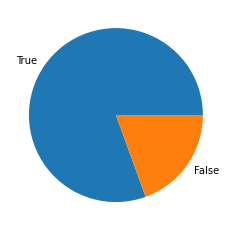

In [12]:
rated_data = df["rated"].value_counts()
plt.pie(rated_data, labels=rated_data.index)

Key Takeaways
* This data is pretty self explanatory. We definitely see more players leaning toward rated games which makes sense because its more competitive.


# How does Rating Affect the Winner?

In [14]:
ratings = []
for i in range(rows):
  if df.iloc[i].winner == "white":
    rating = df.iloc[i].white_rating - df.iloc[i].black_rating
    ratings.append(rating)
  elif df.iloc[i].winner == "black":
    rating = (-1* df.iloc[i].white_rating) + df.iloc[i].black_rating
    ratings.append(rating)
  elif df.iloc[i].winner == "draw":
    if df.iloc[i].white_rating > df.iloc[i].black_rating:
      rating = df.iloc[i].white_rating - df.iloc[i].black_rating
      ratings.append(rating)
    elif df.iloc[i].white_rating < df.iloc[i].black_rating:
      rating = (-1* df.iloc[i].white_rating) + df.iloc[i].black_rating
      ratings.append(rating)
    elif df.iloc[i].white_rating == df.iloc[i].black_rating:
      rating = df.iloc[i].white_rating - df.iloc[i].black_rating
      ratings.append(rating)
ratings = np.asarray(ratings)
df["rating_differences"] = ratings
df.rating_differences.head()

0    309
1    -61
2     -4
3    -15
4     54
Name: rating_differences, dtype: int64

In [15]:
ratings_by_winner = df.groupby("winner").rating_differences.count()
ratings_by_winner.head()

winner
black     9107
draw       950
white    10001
Name: rating_differences, dtype: int64

In [16]:
ratings_by_winner_df = pd.DataFrame()
ratings_by_winner_df["winner"] = df["winner"]
ratings_by_winner_df["rating_differences"] = df["rating_differences"]
ratings_by_winner_df.groupby("winner").rating_differences.count()


winner
black     9107
draw       950
white    10001
Name: rating_differences, dtype: int64

In [17]:
ratings_by_winner_df.head()

,winner,rating_differences
0,white,309
1,black,-61
2,white,-4
3,white,-15
4,white,54


Text(0.5, 1.0, 'Rating Differences vs Winner')

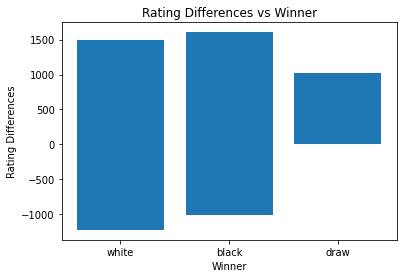

In [18]:
plt.bar(x=ratings_by_winner_df["winner"], height=ratings_by_winner_df["rating_differences"])
plt.xlabel("Winner")
plt.ylabel("Rating Differences")
plt.title("Rating Differences vs Winner")

Key Takeaways


*   The Winners for Black and White seem to vary in rating differences. Sometimes a player is way better  off in terms of ratings, and they win (this is fairly normal and makes complete sense). Vice-verse, we notice that a player that is has a way lower rating still manages to win (this means based off this data alone we can't create clear predictions because the trends aren't obvious to the human eye.


*   The Draw category is also slightly irregular. Its common knowledge that players that are similar in skill will mostly likely end in a draw. We notice that for the most part and give or take a difference in 500, we see that draws are occuring in that skill gap. The outliers (a difference in 500 -> 1000) are showing us that a substantial gap between players are still showing draws. That somewhat makes sense, because with chess its not always clearly predictable, but we still have to dive a little more in-depth to identify more transparent patterns and trends.

*  One crucial factor we have to take into account is that RATINGS ARE NOT A PERFECT INDICATOR OF SKILL. The ratings are solely a guiding variable to help us get a good understanding of a players skills.



# Turns vs Winning Outcome


In [13]:
turns_by_winner = df.groupby("victory_status").turns.count()
turns_by_winner.head()

victory_status
draw           906
mate          6325
outoftime     1680
resign       11147
Name: turns, dtype: int64

In [15]:
turns_by_victory_status_df = pd.DataFrame()
turns_by_victory_status_df["victory_status"] = df["victory_status"]
turns_by_victory_status_df["turns"] = df["turns"]
turns_by_victory_status_df.groupby("victory_status").turns.count()

victory_status
draw           906
mate          6325
outoftime     1680
resign       11147
Name: turns, dtype: int64

Text(0.5, 1.0, 'Turns vs Victory Status')

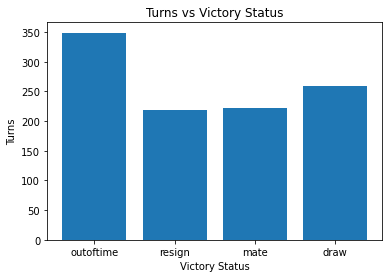

In [19]:
plt.bar(x=turns_by_victory_status_df["victory_status"], height=turns_by_victory_status_df["turns"])
plt.xlabel("Victory Status")
plt.ylabel("Turns")
plt.title("Turns vs Victory Status")

Key Takeaways
* This graph is representing the expected patterns. First and foremost, the outoftime style will obviously have the most turns, because playes keep going back and forth till time runs out. Then resign has roughly from 0 - 200, which confirms our suspicion that players either are leaving early because they just don't want to play, or they get toward the end of the game (200 turns) and know which direction the game is going. For draw and mate, they have the expected turn counts, because it really varies on the games for these values.

# Game Outcome Distribution


In [44]:
df = pd.read_csv("games.csv")

In [45]:
df["victory_status"].value_counts(normalize=True) * 100

resign       55.573836
mate         31.533553
outoftime     8.375710
draw          4.516901
Name: victory_status, dtype: float64

([<matplotlib.patches.Wedge at 0x7f608e603850>,
 [Text(-0.19163499088931965, 1.0831786695955798, 'resign'),
  Text(-0.2506963861046614, -1.0710515029605545, 'mate'),
  Text(0.9395340952862782, -0.5720801375634317, 'outoftime'),
  Text(1.088943531617381, -0.15556987159686797, 'draw')])

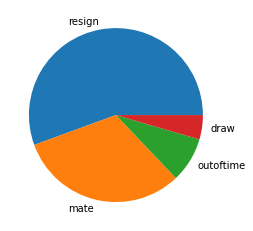

In [46]:
victory_status_data = df["victory_status"].value_counts()
plt.pie(victory_status_data, labels=victory_status_data.index)

Key Takeaways


*   One major factor that is very clear to us is the resign factor. We notice that over 50% (55.57% to be exact) of the games are ending in a resign. From this we can assume a multitude of things. First and foremost, it is shows that some chess players can be impatient or have other commitments that are more important. The second thing we can assume is that a lot of these chess games are having clear outcomes and players are just quitting once they come to a full conclusion that they won't win. To sum it up in order for our model to be more accurate it might be a good idea to think about removing 1/3 or 1/2 of the resign data, because some of these games are going to be irrelevant.





# Stacked Machine Learning Ensemble

Import Neccesary Modules


In [23]:
from xgboost import XGBRegressor
import sklearn
from sklearn.preprocessing import MinMaxScaler, normalize, LabelEncoder, scale
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

In [94]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.2.post1.


Data Preprocessing


In [62]:
df = pd.read_csv("games.csv")

Encode all the labels so that they are numerical for easy machine learning model integration.


In [80]:
df = pd.read_csv("games.csv")
for i in range(rows):
    if df.iloc[i].winner == "white":
      df["winner"][i] = 0
    elif df.iloc[i].winner == "black":
      df["winner"][i] = 1
    else:
      df["winner"][i] = 2
X = df[["rated", "white_rating", "black_rating", "opening_name"]]
X.head()
y = df["winner"]
y=y.astype('int')
print(y.head())


rated_encoder = LabelEncoder()
white_encoder = LabelEncoder()
black_encoder = LabelEncoder()
opening_encoder = LabelEncoder()
winner_encoder = LabelEncoder()

X{"rated"} = rated_encoder.fit_transform(X["rated"])
X["white_rating"] = white_encoder.fit_transform(X["white_rating"])
X["black_rating"] = black_encoder.fit_transform(X["black_rating"])
X["opening_name"] = opening_encoder.fit_transform(X["opening_name"])


X = X.apply(label_encoder.fit_transform)
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train)

X_test_normalized = scaler.fit_transform(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    0
1    1
2    0
3    0
4    0
Name: winner, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Define a few functions that will evaluate the models!

In [60]:
def get_models():
  models = {}
  models["gnb"] = GaussianNB()
  models["lr"] = LogisticRegression()
  models["rfc"] = RandomForestClassifier()
  models["svc"] = SVC()
  models["knn"] = KNeighborsClassifier()
  return models

def eval_model(model, X, y):
  rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=rkf, n_jobs=-1, error_score='raise')
  return scores

Go through a evaluate all the models individually.


In [61]:
model_scores = []
model_names = []

models = get_models()
for name, model in models.items():
  score = eval_model(model, X_train_normalized, y_train)
  model_scores.append(score)
  model_names.append(name)
  print(f"Model: {name}, Score = {mean(score)}, {std(score)}")

Model: gnb, Score = 0.5792433389886096, 0.011029735023634999
Model: lr, Score = 0.6011600978533979, 0.011595775464554635
Model: rfc, Score = 0.6117044341081026, 0.011644278988374479


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Model: svc, Score = 0.5961118387131579, 0.011724442746427621
Model: knn, Score = 0.5706564698635277, 0.014783719157369719


Build the stacked classifier and fit it to the data.

In [62]:
def stacked_model():
  level0 = []
  level0.append(("gnb", GaussianNB()))
  level0.append(('rfc', RandomForestClassifier()))
  level0.append(('svr', SVC()))
  level0.append(('knn', KNeighborsClassifier()))
  level1 = LogisticRegression(solver='lbfgs', max_iter=1000)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, verbose=2)
  return model

def fit_to_dataset(X, y):
  model = stacked_model()
  model.fit(X, y)

  return model

model = fit_to_dataset(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


Dump the model to a pickle file and then load it back (just to make sure it saves).




In [63]:
import pickle                                                             
filename = 'chess_winner_prediction.sav'
pickle.dump(model, open(filename, 'wb'))

with open(filename, "rb") as file:
  model = pickle.load(file)

Get the metrics of the model.


In [92]:
from sklearn.model_selection import train_test_split
train_score = model.score(X_train_normalized, y_train)
print(f"Train Score: {train_score}")
test_score = model.score(X_test_normalized, y_test)
print(f"Test Score: {test_score}")

Train Score: 0.9495201296273215
Test Score: 0.6293619142572283


Simple Prediction Trials

In [84]:
X = pd.DataFrame({"rated" : True, "white_rating" : 1456, "black_rating" : 1654, "opening_name" : "Sicilian Defense"}, index=[0])
X["rated"] = rated_encoder.transform(X["rated"])
X["white_rating"] = white_encoder.transform(X["white_rating"])
X["black_rating"] = black_encoder.transform(X["black_rating"])
X["opening_name"] = opening_encoder.transform(X["opening_name"])
print(X.head)
X = np.array(X)

<bound method NDFrame.head of    rated  white_rating  black_rating  opening_name
0      1           572           781          1194>


In [85]:
winner = model.predict(X)
print(winner)

[1]
